In [11]:
!pip install pandas
!pip install lightning
!pip install pytorch-lightning
!pip install matplotlib
!pip install torchvision


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [85]:
import ssl
import torch
import torchmetrics
import numpy as np
import pandas as pd
from torch import nn
import lightning as L
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Imagenette
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [86]:
class BasicCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional layers (fixed input channels to 1 for grayscale)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 16x16 -> 8x8
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        # Metrics and loss tracking
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_losses = []  # Maintained for manual plotting
        self.val_losses = []    # Maintained for manual plotting

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Manual loss tracking
        self.train_losses.append(loss.detach().cpu().item())
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        # Manual loss tracking
        self.val_losses.append(loss.detach().cpu().item())
        self.accuracy(y_hat, y)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", self.accuracy, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        # Optional: Add epoch-level aggregation
        avg_loss = sum(self.train_losses[-self.trainer.num_training_batches:])/self.trainer.num_training_batches
        print(f"Epoch {self.current_epoch} - Avg Train Loss: {avg_loss:.4f}")

    def on_validation_epoch_end(self):
        # Optional: Add epoch-level aggregation
        if self.val_losses:
            avg_loss = sum(self.val_losses[-self.trainer.num_val_batches[0]:])/self.trainer.num_val_batches[0]
            print(f"Epoch {self.current_epoch} - Avg Val Loss: {avg_loss:.4f}")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=2, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }


In [87]:
class ResNet18(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # Initial convolutional layer (fixed input channels to 3)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_residual_layer(64, 64, stride=1)
        self.layer2 = self._make_residual_layer(64, 128, stride=2)
        self.layer3 = self._make_residual_layer(128, 256, stride=2)
        self.layer4 = self._make_residual_layer(256, 512, stride=2)

        # Classification head
        self.fc = nn.Linear(512, num_classes)

        # Metrics
        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def _make_residual_layer(self, in_channels, out_channels, stride):
        shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride, shortcut),
            ResidualBlock(out_channels, out_channels, 1)
        )
        return layers

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_loss(loss)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.val_loss(loss)
        self.accuracy(y_hat, y)
        self.log("val_loss", self.val_loss, on_epoch=True)
        self.log("val_acc", self.accuracy, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.accuracy(y_hat, y)
        self.log("test_acc", self.accuracy, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=0.1,
            momentum=0.9,
            weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[30, 60], gamma=0.1
        )
        return [optimizer], [scheduler]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, shortcut=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = shortcut

    def forward(self, x):
        residual = x
        if self.shortcut is not None:
            residual = self.shortcut(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)


In [88]:
class RegularizationCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional layers (fixed input channels to 3)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Changed 1 -> 3 channels
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 16x16 -> 8x8
        )

        # Fully connected layers with proper initialization
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout for better balance
            nn.Linear(256, num_classes)
        )

        # Metric tracking
        self.train_loss = torchmetrics.MeanMetric()
        self.val_loss = torchmetrics.MeanMetric()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1)
        return self.fc_layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_loss(loss)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.val_loss(loss)
        self.accuracy(y_hat, y)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", self.accuracy, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.accuracy(y_hat, y)
        self.log("test_acc", self.accuracy, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=2, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }


In [89]:
# Fix SSL certificate issue
ssl._create_default_https_context = ssl._create_unverified_context

def get_transformers(input_size=64, transformer_type="basic_cnn"):

    transformers_obj = {
        "val": transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    }

    if transformer_type == "basic_cnn":
        transformers_obj["train"] = transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    elif transformer_type == "regularization":
        transformers_obj["train"] = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    return transformers_obj

def get_loaders(generated_transforms):
    train_dataset = Imagenette("data/imagenette", split="train",
                               size="160px", download=True,
                               transform=generated_transforms["train"])
    test_dataset = Imagenette("data/imagenette", split="val",
                              size="160px", download=True,
                              transform=generated_transforms["val"])

    # Proper train/val split
    train_set_size = int(len(train_dataset) * 0.9)
    val_set_size = len(train_dataset) - train_set_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_set_size, val_set_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Clone transforms for validation set
    val_dataset.dataset.transform = generated_transforms["val"]

    # Create dataloaders
    BATCH_SIZE = 128
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=8,
                              persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=8,
                            persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2,
                             shuffle=False, num_workers=8,
                             persistent_workers=True)

    loaders = {"train": train_loader, "val": val_loader, "test": test_loader}
    return loaders

# Callbacks
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="min",
    min_delta=0.001
)

checkpoint = ModelCheckpoint(
    monitor="val_acc",
    mode="max",
    dirpath="./checkpoints",
    filename="best_model-{epoch}-{val_acc:.2f}",
    save_top_k=1,
    save_weights_only=True
)


# Basic CNN Model

In [90]:
# Load the dataset
basic_cnn_transforms = get_transformers(input_size=64, transformer_type="basic_cnn")
basic_cnn_loaders = get_loaders(basic_cnn_transforms)
basic_cnn_train_loader = basic_cnn_loaders["train"]
basic_cnn_val_loader = basic_cnn_loaders["val"]
basic_cnn_test_loader = basic_cnn_loaders["test"]

In [91]:
# Trainer configuration
basic_cnn_trainer = L.Trainer(
    max_epochs=10,
    callbacks=[early_stop, checkpoint],
    accelerator="auto",
    devices="auto",
    precision="16-mixed",
    logger=pl_loggers.CSVLogger(save_dir="logs/")
)

Using 16bit Automatic Mixed Precision (AMP)
/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/venv/lib/python3.13/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [92]:
basic_cnn_model = BasicCNN()

# Training execution
basic_cnn_trainer.fit(basic_cnn_model, basic_cnn_train_loader, basic_cnn_val_loader)
basic_cnn_trainer.test(basic_cnn_model, basic_cnn_test_loader)


  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 93.2 K | train
1 | fc_layers   | Sequential         | 2.1 M  | train
2 | train_loss  | MeanMetric         | 0      | train
3 | val_loss    | MeanMetric         | 0      | train
4 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.773     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/venv/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 0: 100%|██████████| 67/67 [00:01<00:00, 45.51it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 67/67 [00:01<00:00, 58.73it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 67/67 [00:01<00:00, 58.45it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 67/67 [00:01<00:00, 59.33it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 67/67 [00:01<00:00, 59.14it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 67/67 [00:01<00:00, 55.86it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 67/67 [00:01<00:00, 57.72it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 67/67 [00:01<00:00, 59.31it/s, v_num=0]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 67/67 [00:01<00:00, 59.23it/s, v_num

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 99.52it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6649681329727173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6649681329727173}]

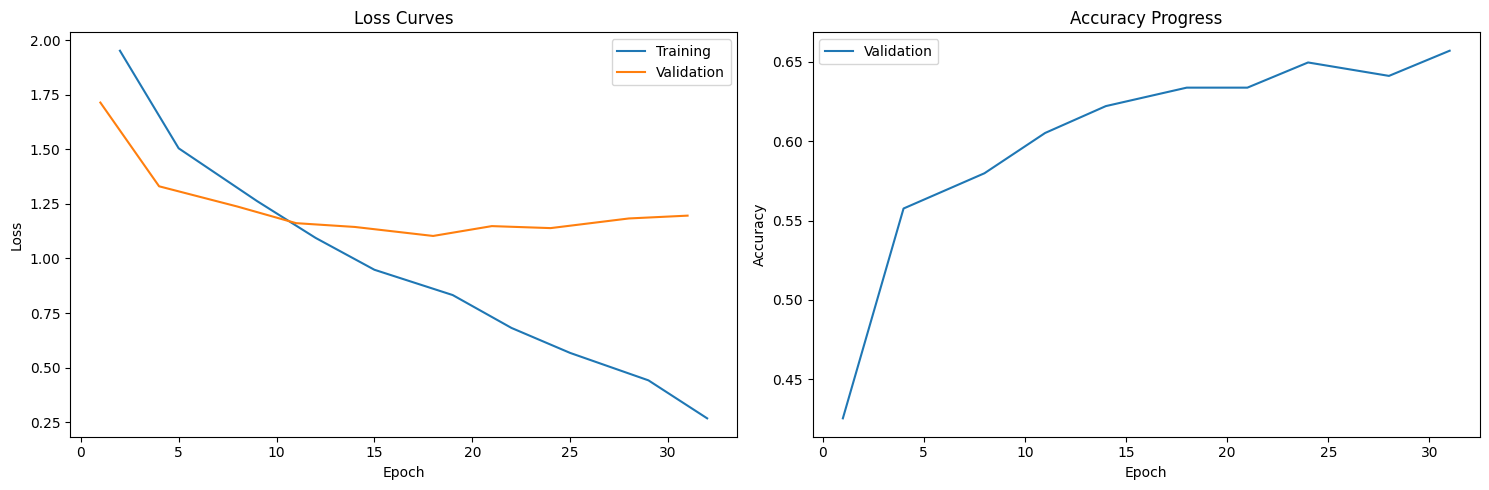

In [94]:
def plot_losses(model):
    plt.figure(figsize=(10, 5))

    # Training loss (all batches)
    plt.plot(model.train_losses, alpha=0.3, label='Training (Batch)')

    # Validation loss (epoch averages)
    val_steps = len(model.val_losses) // len(model.trainer.num_val_batches)
    val_epoch_avg = [np.mean(model.val_losses[i*val_steps:(i+1)*val_steps])
                     for i in range(len(model.trainer.num_val_batches))]
    plt.plot(np.linspace(0, len(model.train_losses), len(val_epoch_avg)),
             val_epoch_avg, label='Validation (Epoch)')

    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()


plot_losses(basic_cnn_trainer)


In [95]:
regularization_transforms = get_transformers(input_size=64, transformer_type="regularization")
regularization_loaders = get_loaders(regularization_transforms)
regularization_train_loader = regularization_loaders["train"]
regularization_val_loader = regularization_loaders["val"]
regularization_test_loader = regularization_loaders["test"]

In [96]:
# Trainer configuration
regularization_trainer = L.Trainer(
    max_epochs=10,
    callbacks=[early_stop, checkpoint],
    accelerator="auto",
    devices="auto",
    precision="16-mixed",
    logger=pl_loggers.CSVLogger(save_dir="logs/")
)

Using 16bit Automatic Mixed Precision (AMP)
/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/venv/lib/python3.13/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [97]:
regularization_model = RegularizationCNN()

# Training execution
regularization_trainer.fit(regularization_model, regularization_train_loader, regularization_val_loader)
regularization_trainer.test(regularization_model, regularization_test_loader)

/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/venv/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints exists and is not empty.
/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 93.2 K | train
1 | fc_layers   | Sequential         | 2.1 M  | train
2 | train_loss  | MeanMetric         | 0      | train
3 | val_loss    | MeanMetric         | 0      | train
4 | accuracy    | MulticlassAccura

/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/venv/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 0: 100%|██████████| 67/67 [00:01<00:00, 43.52it/s, v_num=1]
Validation: |          | 0/? [00:00<?, ?it/s]
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 98.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3974522352218628
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.3974522352218628}]

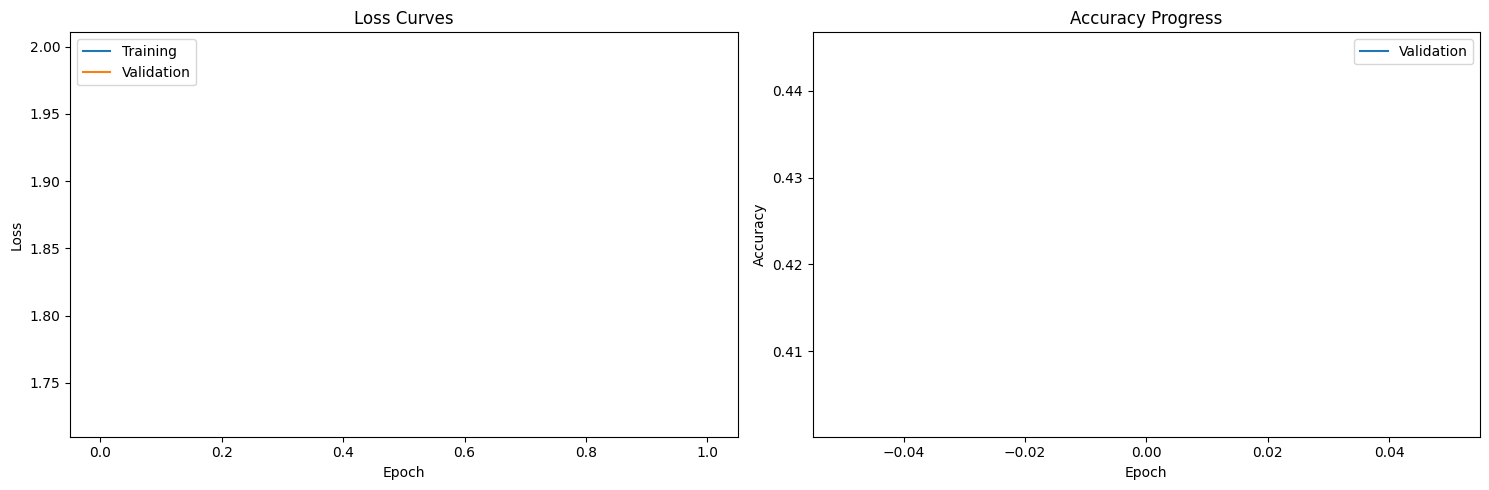

In [98]:
def plot_regularization_losses(trainer):
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'].dropna(), label='Training')
    plt.plot(metrics['val_loss'].dropna(), label='Validation')
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['val_acc'].dropna(), label='Validation')
    plt.title("Accuracy Progress")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_regularization_losses(regularization_trainer)